<a href="https://colab.research.google.com/github/iiamthestorm/Bangkit-C22-PS353-MachineLearning/blob/main/Price_Forecasting_with_CNN_RNN_DNN_Beras_Kualitas_Medium_II_(2_di_awal_koma)_(kg)_(Produsen_2019_2022).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install tensorflow, Import that smooth library

In [19]:
# import that smooth library

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import csv
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from plotly.subplots import make_subplots

# Download the Data

In [20]:
# prepare the dataset, 
# download data from google drive
# https://drive.google.com/file/d/1ZP1ixxSOpkPETRpkplFMc8p0buEOymKk/view?usp=sharing

!gdown --id 1ZP1ixxSOpkPETRpkplFMc8p0buEOymKk

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZP1ixxSOpkPETRpkplFMc8p0buEOymKk
To: /content/Beras Kualitas Medium II (2 di awal koma) Produsen 2019-2022.csv
100% 15.6k/15.6k [00:00<00:00, 18.8MB/s]


# Preprocess the data

In [21]:
# read the dataset and convert into csv
df = pd.read_csv('Beras Kualitas Medium II (2 di awal koma) Produsen 2019-2022.csv')
# show me that csv
print(df)

     Unnamed: 0        Date  Price
0             0  2019-03-01   94.0
1             1  2019-03-04   94.0
2             2  2019-03-05   94.5
3             3  2019-03-06   94.5
4             4  2019-03-08   94.5
..          ...         ...    ...
776         776  2022-04-26   88.5
777         777  2022-04-27   88.5
778         778  2022-04-28   88.5
779         779  2022-04-29   88.5
780         780  2022-05-09   88.5

[781 rows x 3 columns]


# Visualize the Dataset

In [22]:
# put x and y axis respectively
fig = px.line(df, x='Date', y='Price')

# this code is to add the range slider so we can see better
fig.update_xaxes(rangeslider_visible=True)

# for showing the plot
fig.show()

# Setting up the plot function for plotting

In [23]:
def plot_series(x, y, format="-", start=0, end=None, 
                title='Price Forecasting ML Model with CNN_RNN_DNN', xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(16, 8))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Preview the Dataset

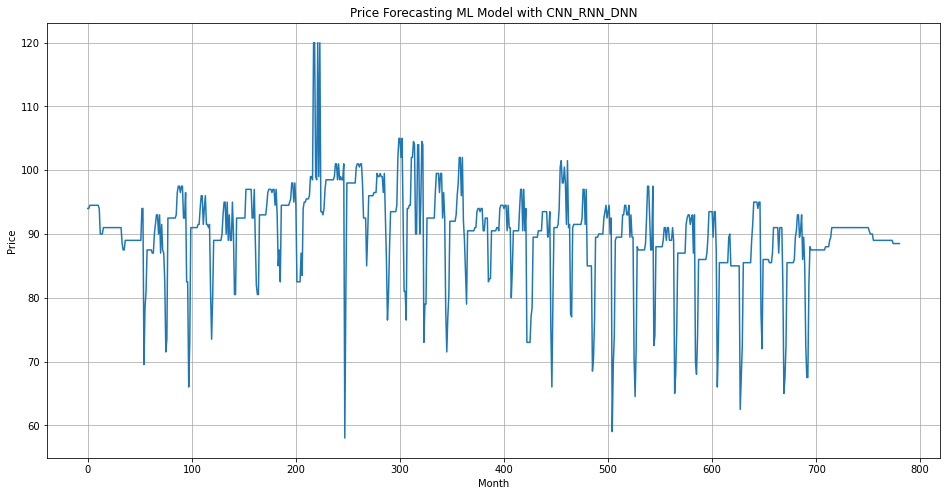

In [24]:
# Initialize lists
time_step = []
price = []

# Open CSV file
with open('./Beras Kualitas Medium II (2 di awal koma) Produsen 2019-2022.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    price.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(price)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Price')

In [25]:
print(type(time))
print(type(series))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Split the Dataset

In [26]:
# Define the split time
split_time = 650

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

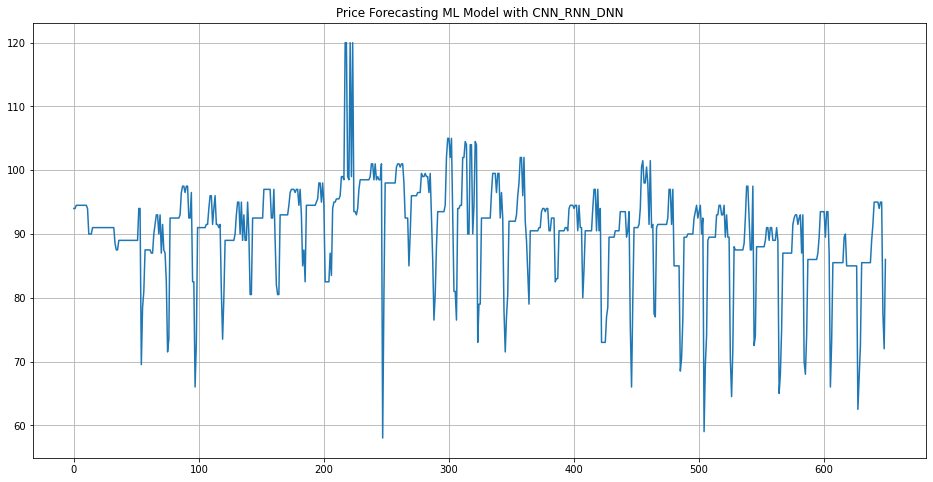

In [27]:
# Plot the train set
plot_series(time_train, x_train)

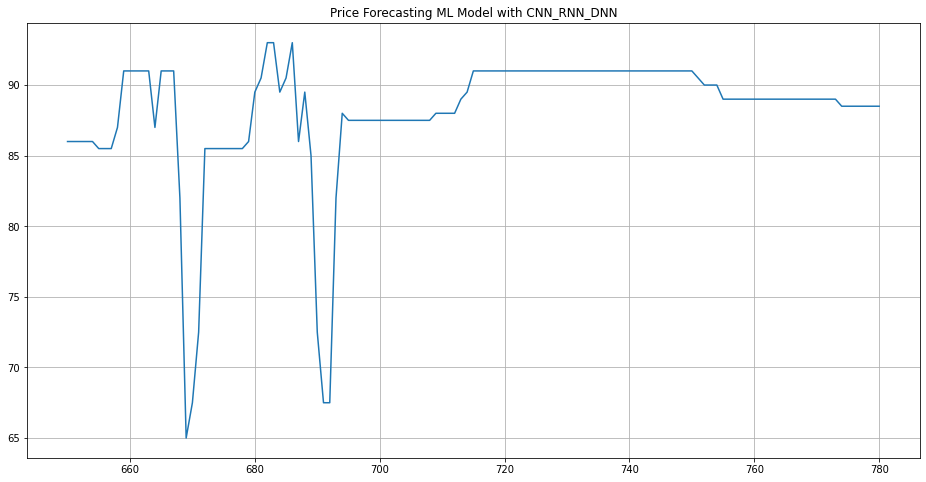

In [28]:
# Plot the validation set
plot_series(time_valid, x_valid)

# Prepare Features and Labels

In [29]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

As mentioned in the lectures, if your results don't good, you can try tweaking the parameters here and see if the model will learn better.

In [30]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build the Model
You've seen these layers before and here is how it's looks like when combined.

In [31]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

# Tune the Learning Rate
As usual, you will want to pick an optimal learning rate.

In [32]:
# Get initial weights
init_weights = model.get_weights()

In [33]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
20/20 [==============================] - 5s 43ms/step - loss: 119.7446 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 1s 41ms/step - loss: 112.5153 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 1s 40ms/step - loss: 103.9416 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 1s 41ms/step - loss: 95.0046 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 1s 42ms/step - loss: 86.0793 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 1s 42ms/step - loss: 78.6957 - lr: 1.7783e-08
Epoch 7/100
20/20 [==============================] - 1s 45ms/step - loss: 72.0566 - lr: 1.9953e-08
Epoch 8/100
20/20 [==============================] - 1s 42ms/step - loss: 66.6633 - lr: 2.2387e-08
Epoch 9/100
20/20 [==============================] - 1s 44ms/step - loss: 62.0919 - lr: 2.5119e-08
Epoch 10/100
20/20 [==============================] - 1s 42ms/step - loss: 57.4897 - lr: 2.8184e-08
Epoch 

(1e-08, 0.001, 0.0, 100.0)

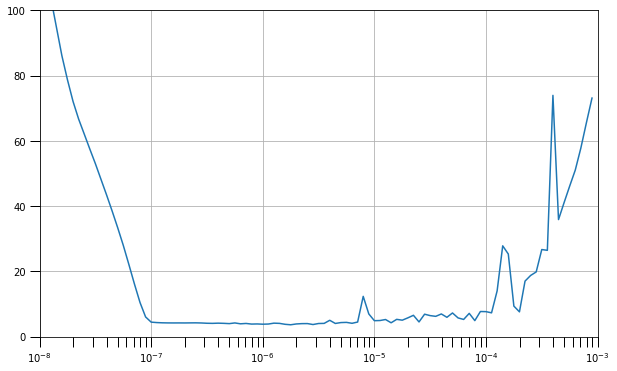

In [34]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

# Now let’s compile and train the model
Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [35]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [36]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [37]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
20/20 [==============================] - 5s 46ms/step - loss: 66.4951 - mae: 66.9951
Epoch 2/100
20/20 [==============================] - 1s 50ms/step - loss: 7.7169 - mae: 8.2028
Epoch 3/100
20/20 [==============================] - 1s 43ms/step - loss: 5.3045 - mae: 5.7830
Epoch 4/100
20/20 [==============================] - 1s 43ms/step - loss: 4.9417 - mae: 5.4160
Epoch 5/100
20/20 [==============================] - 1s 43ms/step - loss: 4.6295 - mae: 5.1056
Epoch 6/100
20/20 [==============================] - 1s 41ms/step - loss: 4.6220 - mae: 5.0966
Epoch 7/100
20/20 [==============================] - 1s 41ms/step - loss: 4.5720 - mae: 5.0469
Epoch 8/100
20/20 [==============================] - 1s 41ms/step - loss: 4.5127 - mae: 4.9864
Epoch 9/100
20/20 [==============================] - 1s 40ms/step - loss: 4.5482 - mae: 5.0199
Epoch 10/100
20/20 [==============================] - 1s 40ms/step - loss: 4.4783 - mae: 4.9529
Epoch 11/100
20/20 [===========================

You can visualize the training and see if the loss and MAE are still trending down.

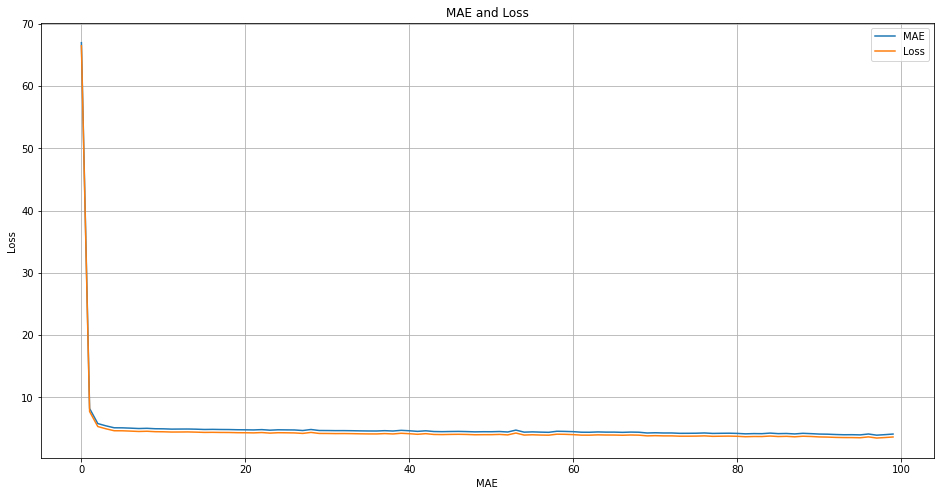

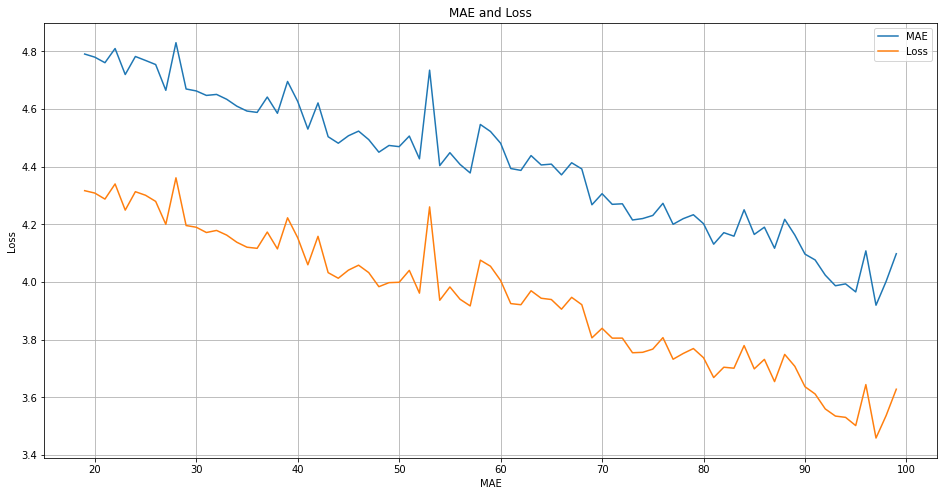

In [38]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [39]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

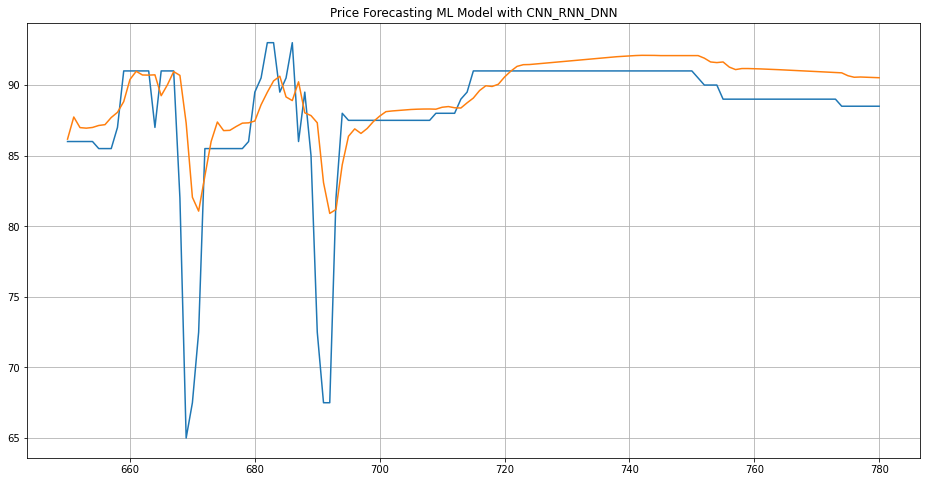

In [40]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [41]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

2.0294921


## Optional

In this optional section, you will look at another way to dynamically set the learning rate. As you may have noticed, training for a long time generates less and less changes to the loss and metrics. You can run the cell below to observe that again.

In [42]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
20/20 [==============================] - 5s 41ms/step - loss: 3.4136 - mae: 3.8679
Epoch 2/10
20/20 [==============================] - 1s 43ms/step - loss: 3.3784 - mae: 3.8330
Epoch 3/10
20/20 [==============================] - 1s 40ms/step - loss: 3.3763 - mae: 3.8314
Epoch 4/10
20/20 [==============================] - 1s 41ms/step - loss: 3.3605 - mae: 3.8161
Epoch 5/10
20/20 [==============================] - 1s 41ms/step - loss: 3.3839 - mae: 3.8400
Epoch 6/10
20/20 [==============================] - 1s 40ms/step - loss: 3.4138 - mae: 3.8722
Epoch 7/10
20/20 [==============================] - 1s 41ms/step - loss: 3.3871 - mae: 3.8524
Epoch 8/10
20/20 [==============================] - 1s 42ms/step - loss: 3.3620 - mae: 3.8223
Epoch 9/10
20/20 [==============================] - 1s 42ms/step - loss: 3.3676 - mae: 3.8255
Epoch 10/10
20/20 [==============================] - 1s 42ms/step - loss: 3.3540 - mae: 3.8092


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.

In [43]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
20/20 [==============================] - 6s 43ms/step - loss: 3.3630 - mae: 3.8168
Epoch 2/40
20/20 [==============================] - 1s 41ms/step - loss: 3.3576 - mae: 3.8204
Epoch 3/40
20/20 [==============================] - 1s 41ms/step - loss: 3.3560 - mae: 3.8074
Epoch 4/40
20/20 [==============================] - 1s 41ms/step - loss: 3.3475 - mae: 3.8012
Epoch 5/40
20/20 [==============================] - 1s 42ms/step - loss: 3.3480 - mae: 3.8094
Epoch 6/40
20/20 [==============================] - 1s 42ms/step - loss: 3.3460 - mae: 3.7988
Epoch 7/40
20/20 [==============================] - 1s 40ms/step - loss: 3.3465 - mae: 3.7989
Epoch 8/40
20/20 [==============================] - 1s 42ms/step - loss: 3.3273 - mae: 3.7829
Epoch 9/40
20/20 [==============================] - 1s 44ms/step - loss: 3.4044 - mae: 3.8739
Epoch 10/40
20/20 [==============================] - 1s 43ms/step - loss: 3.3671 - mae: 3.8232
Epoch 11/40
20/20 [==============================] - 1s 42m

Now see the results by geting predicitons and computing the metrics.

In [44]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
# plot_series(time_valid, (x_valid, results))

In [45]:
df_valid = pd.DataFrame({'Time_Valid': time_valid,
                   'X_Valid': x_valid,
                   'Results': results})

In [46]:
print(df_valid)

     Time_Valid  X_Valid    Results
0           650     86.0  85.932335
1           651     86.0  87.794495
2           652     86.0  87.018715
3           653     86.0  86.966637
4           654     86.0  87.041512
..          ...      ...        ...
126         776     88.5  90.676994
127         777     88.5  90.703903
128         778     88.5  90.690605
129         779     88.5  90.672707
130         780     88.5  90.659203

[131 rows x 3 columns]


In [47]:
fig = px.line(df_valid, x="Time_Valid", y=df_valid.columns)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [48]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.0909693